# Modelization of a battery / PV / consumer system

The objective of this Notebook is to model the system described in the document "Layout & equations":

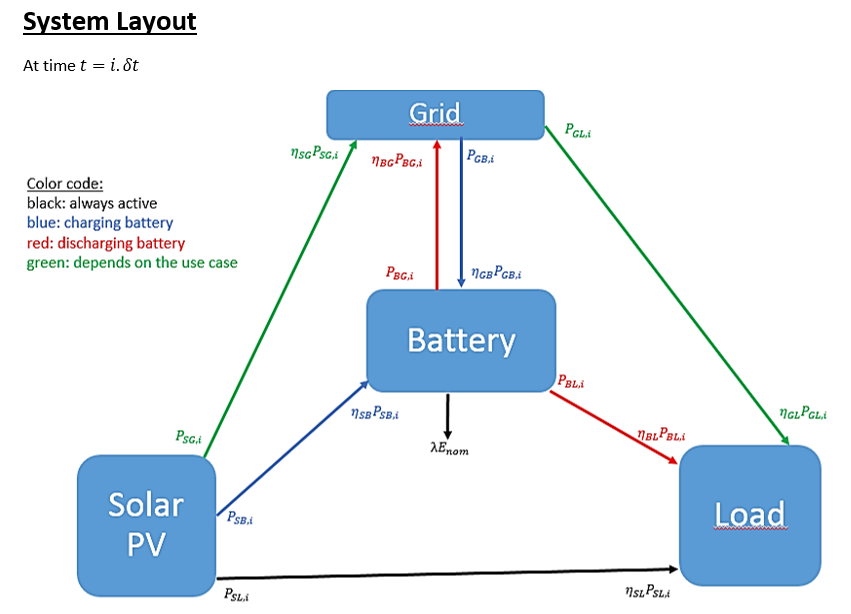

At a given time, the values of these energy exchanges depend on different factors: 
- PV output
- Load amount (corresponds to the energy consumed by the client)
- Battery's state of charge
- Grid consumption setpoint

We don't have any control on the PV output and on the load.
The priorities are: 
- At each time, **the required load has to be satisfied.**
- *The self-consumption of the PV energy output has to be maximized (we will try never to sell PV energy to the grid)*

The most important component here, and the only one over which we have control, is the **battery**. The battery has certain operating constraints that have to be respected, otherwise it can be severely damaged: 
- Maximum charging power Pmax
- Maximum and minimum states of charge (SOCmax and SOCmin)

## Optimisation principles

Given these limitations, the objective of this study is to **determine, over a 24h period, the optimal grid consumption profile that minimizes the total cost of electricity consumed from the grid.**  
This grid consumption profile is closely linked to the battery charging-discharging profile, as the battery is the only component over which we have control, hence that we can optimize.

The basic principle is that:
- when the electricity tariffs are low:
        - we should over-consume from the grid and store the excess (after satisfaction of the load) in the battery
- when the electricity tariffs are high:
        - we should under-consume from the grid and satisfy the load with the energy previously stored in the battery

We will see later that many parameters have to be taken into account in the optimization, like:
- the **ageing cost** of cycling the battery (not worth cycling the battery if the associated earnings are inferior to the ageing cost caused by this cycle)
- the **over-capacity cost** (cost paid when taking from the grid a power superior to what the client is allowed to, according to its electricity subscription contract)
- etc...

Finally, the output of the optimization will be: **an optimal grid consumption profile.**

## The Controller

Once we obtain the optimal grid consumption profile, we have to apply it the best we can in real conditions, that is to say by ensuring that we **always respect the battery's operating constraints.**

That is the role of the **Controller**.

__Inputs:__  
   - 24h load prediction
   - 24h PV output prediction
   - 24h grid consumption setpoint (given by the optimisation algorithm)
   
__Output:__
- 24h grid consumption setpoint respecting the battery's operating constraints


## Analytic modelization

#### Definition of variables  
*cf reference document*

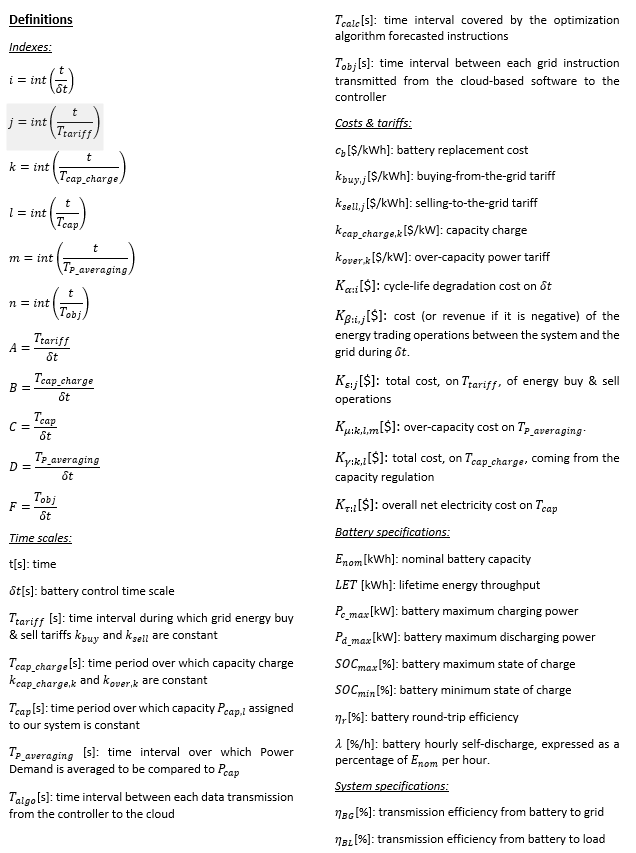
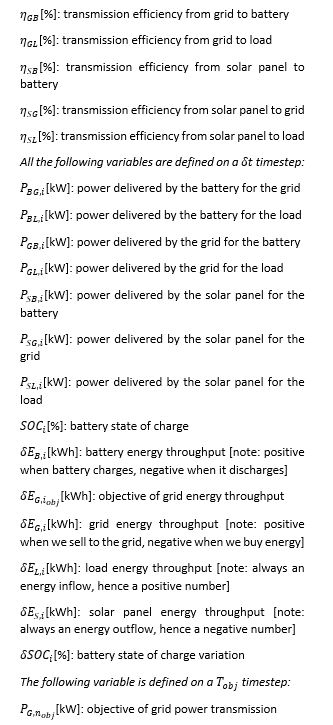

In [19]:
import numpy as np
from math import sqrt

In [20]:
#Time scales
T_calc = 3600 * 24             #[s] optimization over 24h
T_obj = 30 * 60                #[s] grid instruction every 30min
n_inst = int(T_calc / T_obj)   #number of grid instructions over T_calc
d_t = T_obj                    #[s] time-step - division in sub-instructions to monitor the 
                               #battery's real behaviour
F = int(T_obj / d_t)           #number of sub-instructions over T_obj

#Transmission efficiency 
eta_BG = 0.9
eta_BL = 0.9
eta_GB = 0.9
eta_GL = 0.9
eta_SB = 0.9
eta_SG = 0.9
eta_SL = 0.9

#Energy consumed or produced
E_L = np.ones(n_inst*F) #[kWh] energy required by the load (positive)
E_S = np.ones(n_inst*F) #[kWh] energy produced by the PV panels (negative)
E_G = np.ones(n_inst*F) #[kWh] grid energy purchase or selling (positive if sell, neg if purchase)

# #Power exchanges
# P_BG = np.ones(n_inst*F)
# P_BL = np.ones(n_inst*F)
# P_GB = np.ones(n_inst*F)
# P_GL = np.ones(n_inst*F)
# P_SB = np.ones(n_inst*F)
# P_SG = np.ones(n_inst*F)
# P_SL = np.ones(n_inst*F)

#Battery
SOC = np.ones(n_inst*F)*0.5 #SOC on a d_t granularity (input for sub-instructions)
SOC_max = 0.9
SOC_min = 0.1
E_nom = 1000 #[kWh] Nominal capacity
eta_r = 0.87 #round-trip efficiency
lambda_ = 0.05 #[%/h] hourly self-discharge
P_cmax = 500 #max charging power
P_dmax = 500 #max discharging power
c_B = 300000 #[$] battery replacement cost
LET = 3650 * E_nom #[kWh] nb max cycles full DOD * capacity -> Lifetime energy throughput

#Tariffs
k_buy = np.ones(n_inst*F)
k_sell = np.ones(n_inst*F)

#Costs
K_age = np.zeros(n_inst*F)
K_trad = np.zeros(n_inst*F)

#### Grid instructions

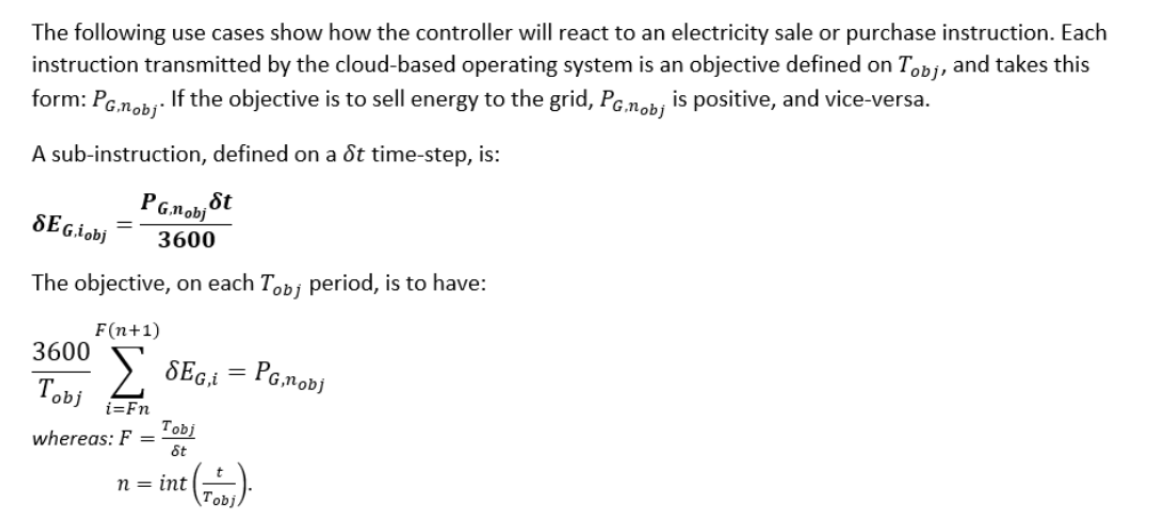

In [3]:
#Define grid instructions variables
# P_G_obj = 1/eta_GL*(3600/d_t*E_L - eta_SL*P_SL)        #grid power purchase or selling instructions with d_t granularity
#                                                        #initialized considering there is no battery
# E_G_obj = P_G_obj * d_t/3600    #grid energy purchase or selling instructions with d_t granularity

#### Controller use-cases

In [4]:
def controller(E_L_i, E_S_i, P_G_obj_i, SOC_i, k_buy_i, k_sell_i):
    
    global P_SB_i
    global P_BG_i
    global P_BL_i
    global P_GB_i
    global P_GL_i
    global P_SB_i
    global P_SG_i
    global P_SL_i
    
    
    E_G_obj_i = P_G_obj_i * d_t/3600
    #Sell to grid
    if P_G_obj_i >= 0:
        P_GB_i = 0
        
        #PV output is enough to satisfy the load
        if eta_SL * E_S_i + E_L_i <= 0:
            P_BL_i = 0
            P_GL_i = 0
            P_SL_i = 1 / eta_SL * 3600/d_t * E_L_i
            
            #Remaining PV output is enough to satisfy the grid energy sale objective
            if eta_SG * (E_S_i + 1/eta_SL * E_L_i) + E_G_obj_i <= 0:
                P_BG_i = 0
                
                #Battery can store the leftover PV output
                if SOC_i * E_nom - eta_SB * sqrt(eta_r)*(E_S_i + 1/eta_SL * E_L_i 
                            + 1/eta_SG *E_G_obj_i) -lambda_*E_nom*d_t/3600 <= SOC_max * E_nom:
                    
                    #Without exceeding its maximum charging power
                    #-> selling target achieved
                    if -eta_SB*(3600/d_t*E_S_i + P_SL_i + 1/eta_SG*3600/d_t*E_G_obj_i) <= P_cmax:
                        P_SG_i = 1/eta_SG * 3600/d_t * E_G_obj_i
                        P_SB_i = -(3600/d_t*E_S_i + P_SG_i + P_SL_i)
                    
                    #But is limited by its maximum charging power, so PV gives more to grid
                    #-> selling target exceeded
                    else: 
                        P_SB_i = 1/eta_SB*P_cmax
                        P_SG_i = -(3600/d_t*E_S_i + P_SB_i + P_SL_i)
               
                #Battery cannot store ALL remaining PV output
                #-> selling target exceeded
                else:
                    
                    #And it can be charged up to SOC_max, the rest of PV output going to the grid
                    if 1/sqrt(eta_r) * ((SOC_max - SOC_i)*3600/d_t*E_nom + lambda_*E_nom) <= P_cmax:
                        P_SB_i = 1/(eta_SB*sqrt(eta_r)) * ((SOC_max - SOC_i)*3600/d_t*E_nom\
                        +lambda_*E_nom)
                        P_SG_i = -(3600/d_t*E_S_i + P_SB_i + P_SL_i)
                        
                    #And due to charging power limitation, PV gives maximum charging power,
                    #and the rest goes to the grid
                    else:
                        P_SB_i = 1/eta_SB * P_cmax
                        P_SG_i = -(3600/d_t*E_S_i + P_SB_i + P_SL_i)
            
            #Remaining PV output is not enough to satisfy the grid energy sale objective
            else:
                P_SB_i = 0
                P_SG_i = -(3600/d_t*E_S_i + P_SL_i)
                
                #Battery is enough to satisfy the remaining grid energy sale objective
                if -eta_BG*sqrt(eta_r)*((SOC_i-SOC_min)*E_nom - d_t/3600*lambda_*E_nom)\
                + E_G_obj_i - d_t/3600*eta_SG*P_SG_i <= 0:
                    
                    #And is not limited by its discharging power
                    #-> selling target achieved
                    if 1/eta_BG * (3600/d_t*E_G_obj_i - eta_SG*P_SG_i) <= P_dmax:
                        P_BG_i = 1/eta_BG * (3600/d_t*E_G_obj_i - eta_SG*P_SG_i)
                        
                    #But is limited by its discharging power
                    #-> selling target unreached
                    else:
                        P_BG_i = P_dmax
                
                #Battery is not enough to satisfy the remaining grid energy sale objective
                #-> selling target unreached
                else:
                    
                    #Not limited by its discharging power: discharges into grid up to SOC_min
                    if sqrt(eta_r) * ((SOC_i-SOC_min)*3600/d_t*E_nom - lambda_*E_nom) <= P_dmax:
                        P_BG_i = sqrt(eta_r) * ((SOC_i-SOC_min)*3600/d_t*E_nom - lambda_*E_nom)
                    
                    #Limited by its discharging power
                    else:
                        P_BG_i = P_dmax
                
        #PV output isn’t enough to satisfy the load
        else:
            P_SG_i = 0
            P_SB_i = 0
            P_SL_i = -3600/d_t * E_S_i
            
            #Battery is enough to satisfy the remaining load
            if -eta_BL*sqrt(eta_r)*((SOC_i-SOC_min)*E_nom - lambda_*E_nom*d_t/3600)\
            + eta_SL*E_S_i + E_L_i <= 0:
                
                #And is not limited by its discharging power
                if 1/eta_BL*(eta_SL*3600/d_t*E_S_i + 3600/d_t*E_L_i) <= P_dmax:
                    P_BL_i = 1/eta_BL*(eta_SL*3600/d_t*E_S_i + 3600/d_t*E_L_i)
                    P_GL_i = 0
                    
                    #Remaining battery is enough to satisfy the grid energy sale objective
                    if -eta_BG*sqrt(eta_r)*((SOC_i-SOC_min)*E_nom - lambda_*E_nom*d_t/3600\
                    - P_BL_i*d_t/3600) + E_G_obj_i <= 0:
                        
                        #And is not limited by its discharging power
                        #-> selling target achieved
                        if 1/eta_BG*3600/d_t*E_G_obj_i <= P_dmax :
                            P_BG_i = 1/eta_BG*3600/d_t*E_G_obj_i
                        
                        #But is limited by its discharging power
                        #-> selling target unreached 
                        else:
                            P_BG_i = P_dmax
                    
                    #Remaining battery is not enough to satisfy the grid energy sale objective
                    #-> selling target unreached
                    else:
                        
                        #Not limited by its discharging power: discharges into grid up to SOC_min
                        if sqrt(eta_r)*((SOC_i-SOC_min)*3600/d_t*E_nom - lambda_*E_nom) <= P_dmax:
                            P_BG_i = sqrt(eta_r)*((SOC_i-SOC_min)*3600/d_t*E_nom - lambda_*E_nom)
                        
                        #Limited by its discharging power
                        else:
                            P_BG_i = P_dmax
                
                # But is limited by its discharging power
                #-> we have to buy from the grid
                else:
                    P_BL_i = P_dmax
                    P_GL_i = 1/eta_GL*(3600/d_t*E_L_i - eta_BL*P_BL_i - eta_SL*P_SL_i)
                    P_BG_i = 0
                
            #Battery isn’t enough to satisfy the remaining load
            #-> we have to buy from the grid
            else:
                P_BG_i = 0
                
                #Not limited by its discharging power: discharges into load up to SOC_min
                if sqrt(eta_r)*((SOC_i-SOC_min)*3600/d_t*E_nom - lambda_*E_nom) <= P_dmax:
                    P_BL_i = sqrt(eta_r)*((SOC_i-SOC_min)*3600/d_t*E_nom - lambda_*E_nom)
                    P_GL_i = 1/eta_GL*(3600/d_t*E_L_i - eta_BL*P_BL_i - eta_SL*P_SL_i)
                    
                #Limited by its discharging power
                else:
                    P_BL_i = P_dmax
                    P_GL_i = 1/eta_GL*(3600/d_t*E_L_i - eta_BL*P_BL_i - eta_SL*P_SL_i)


    #Buy from grid
    #else:
    
           
                        
    #Compute the outputs:
    
    #Components outputs
    #Battery's energy output
    E_B_i = sqrt(eta_r)*(eta_SB*P_SB_i+eta_GB*P_GB_i)*d_t/3600 - 1/sqrt(eta_r)*(eta_BL*P_BL_i + eta_BG*P_BG_i)\
    *d_t/3600 - lambda_*E_nom*d_t/3600
    
    #New state of charge, after applying the outputs
    SOC_next = SOC_i + E_B_i/E_nom
    
    #grid's power and energy output
    E_G_i = (eta_SG*P_SG_i + eta_BG*P_BG_i - P_GB_i - P_GL_i)*d_t/3600
    P_G_i = (eta_SG*P_SG_i + eta_BG*P_BG_i - P_GB_i - P_GL_i)
    
    
        #output is E_G_i, that has to be compared with E_G_obj. Need to compare if d_t < T_obj, otherwise useless,
        #if the objective is not reached we can't do anything anymore as we already enter a new T_obj, with a new
        #tariff. We suppose that T_obj = T_tariff
        #The only output that will be used as an input for the next controlling round is SOC_i. The optimization
        #profile is done before using the controller, and we don't re-run any optimization: the system will try
        #to apply the instructions as much as possible, while respecting the battery's constraints.
        #E.g: have to fully discharge until SOC_min. Pb: limited by P_dmax, hence after going through
        #the controller, the real battery output changes, and is SOC_min + X. No need to re-run the optimization
        
        #graph E_G and E_L (or rather P_G and P_L) on a single graph will allow to see the impact of the battery
        
    #Costs outputs
    #Battery's ageing cost
    K_age_i = c_B*E_nom/LET * sqrt(eta_r)*(eta_GB*P_GB_i + eta_SB*P_SB_i)*d_t/3600
    
    #Energy trading
    K_trad_i = - k_buy_i*min(0, E_G_i) - k_sell_i*max(0, E_G_i)
    
    #Demand-charge and reserve aspects can be added later
        
    #We now have electricity costs associated to grid's instruction after remodeling by the 
    #controller. 
    #We can now get the outputs, and use these costs as a KPI for the optimization
    
    return P_G_i, SOC_next, K_age_i + K_trad_i

In [16]:
controller(12, 1, 400, 0.3, 2, 3)

(293.81244017229756, 0.10366974830059245, -440.71866025844633)